In [ ]:
!pip install torchviz

In [ ]:
import pickle
import nltk
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchsummary import summary
from torchviz import make_dot
from sklearn.metrics import log_loss, hamming_loss, accuracy_score, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from gensim.models.doc2vec import Doc2Vec
from nltk.tokenize import word_tokenize
from PIL import Image
from tqdm import tqdm
nltk.download('punkt')
plt.rcParams['figure.figsize'] = (10, 8)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp -r "/content/drive/Shareddrives/CIS 522 Final Project/shopee-product-matching.zip" .
!unzip "/content/shopee-product-matching.zip"

Archive:  /content/shopee-product-matching.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
batch_size = 256

In [ ]:
!nvidia-smi

Sat May  1 19:48:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pd.read_csv('/content/drive/Shareddrives/CIS 522 Final Project/Data/triplet_train.csv').head()

,posting_id_anchor,image_anchor,image_phash_anchor,title_anchor,label_group_positive,posting_id_positive,image_positive,image_phash_positive,title_positive,posting_id_negative,image_negative,image_phash_negative,title_negative,label_group_negative
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,train_2278313361,f83b49a86a0ee8592e3bf0204da3fbdf.jpg,ac63931c3d4b42f6,PAPER BAG VICTORIA SECRET,train_3913190043,7da59b1a67f68341b28670feeb76dfb2.jpg,fc13826cf03a9673,OTAJI Oseng Tuna Asap 500gr,2963928868
1,train_2278313361,f83b49a86a0ee8592e3bf0204da3fbdf.jpg,ac63931c3d4b42f6,PAPER BAG VICTORIA SECRET,249114794,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,train_1007590256,1a3013542c558927db0d8c1de61690a1.jpg,a8049efee5c1627a,{LAMPU TUMBLR / LAMPU NATAL / TWINKLE LIGHT / ...,2014040846
2,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,train_3423213080,8cbe4bf9706bc177fd61071ef776be8c.jpg,bfc6d01bc72c1d30,Double Tape VHB 3M ORIGINAL 12mm x 4.5mm Busa ...,train_3069587451,da80703ef767b8650acbee00f358280d.jpg,93e67c6a6159a6c1,Yazole 318 Jam Tangan Pria Original Business Q...,80347885
3,train_3423213080,8cbe4bf9706bc177fd61071ef776be8c.jpg,bfc6d01bc72c1d30,Double Tape VHB 3M ORIGINAL 12mm x 4.5mm Busa ...,2937985045,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",train_3446162576,c86c2afa855bc03a79f14bde79548ffe.jpg,dea1c13e523ea3a1,Garnier Color Naturals Express Creme 3 - Cokla...,2910074820
4,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,train_3803689425,75dbd1e9f31f2d0f21d31c08b3e0b94e.jpg,eb969469cd384ac6,Maling Ham Pork Luncheon Meat TTS 397gr,train_4248829581,5107e9669190bbf101ebdbfabb1acab5.jpg,f0aab378aa113e72,[Per Pc] Liptint Sasimi Aloe Vera 99%,1544174053


In [ ]:
train_transforms = transforms.Compose([
                                       transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                       transforms.ColorJitter(),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.Resize(size=256),
                                       transforms.CenterCrop(size=224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                       ])
inference_transforms = transforms.Compose([
                                      transforms.Resize(size=256),
                                      transforms.CenterCrop(size=224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])

In [ ]:
class ShopeeDatasetTrain(Dataset):

    def __init__(self, csv_file, transform=None, folder='train'):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dataframe = pd.read_csv(csv_file)
        self.nlp_model = Doc2Vec.load('/content/drive/Shareddrives/CIS 522 Final Project/Models/d2v.model')
        self.transform = transform
        self.folder = folder

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        anchor_image = Image.open('{}_images/{}'.format(self.folder, self.dataframe.loc[idx, 'image_anchor']))
        positive_image = Image.open('{}_images/{}'.format(self.folder, self.dataframe.loc[idx, 'image_positive']))
        negative_image = Image.open('{}_images/{}'.format(self.folder, self.dataframe.loc[idx, 'image_negative']))

        
        anchor_text = self.nlp_model.infer_vector(word_tokenize(self.dataframe.loc[idx, 'title_anchor'].lower()))
        positive_text = self.nlp_model.infer_vector(word_tokenize(self.dataframe.loc[idx, 'title_positive'].lower()))
        negative_text = self.nlp_model.infer_vector(word_tokenize(self.dataframe.loc[idx, 'title_negative'].lower()))

        if self.transform:
            anchor_image = self.transform(anchor_image)
            positive_image = self.transform(positive_image)
            negative_image = self.transform(negative_image)

        sample = anchor_image.cuda().float(), positive_image.cuda().float(), negative_image.cuda().float(), torch.from_numpy(anchor_text).cuda().float(), torch.from_numpy(positive_text).cuda().float(), torch.from_numpy(negative_text).cuda().float()

        return sample

In [ ]:
class ShopeeDatasetInference(Dataset):

    def __init__(self, csv_file, transform=None, folder='train'):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dataframe = pd.read_csv(csv_file)
        self.nlp_model = Doc2Vec.load('/content/drive/Shareddrives/CIS 522 Final Project/Models/d2v.model')
        self.transform = transform
        self.folder = folder

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        
        image = Image.open('{}_images/{}'.format(self.folder, self.dataframe.loc[idx, 'image_anchor']))
        text = self.nlp_model.infer_vector(word_tokenize(self.dataframe.loc[idx, 'title_anchor'].lower()))
        label = self.dataframe.loc[idx, 'label_group_positive']
        

        if self.transform:
            image = self.transform(image)

        sample = image.cuda().float(), torch.from_numpy(text).cuda().float(), label

        return sample

In [ ]:
train_dataset = ShopeeDatasetTrain('/content/drive/Shareddrives/CIS 522 Final Project/Data/triplet_train.csv', transform=train_transforms, folder='train')
valid_dataset = ShopeeDatasetTrain('/content/drive/Shareddrives/CIS 522 Final Project/Data/triplet_valid.csv', transform=inference_transforms, folder='train')
inference_dataset = ShopeeDatasetInference('/content/drive/Shareddrives/CIS 522 Final Project/Data/triplet_valid.csv', transform=inference_transforms, folder='train')

# train_dataset = ShopeeDatasetTrain('/content/drive/Shareddrives/CIS 522 Final Project/Data/triplet_train_sample.csv', transform=train_transforms, folder='train')
# valid_dataset = ShopeeDatasetTrain('/content/drive/Shareddrives/CIS 522 Final Project/Data/triplet_valid_sample.csv', transform=inference_transforms, folder='train')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
inference_loader = DataLoader(inference_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class FullNet(nn.Module):   
    def __init__(self):
        super(FullNet, self).__init__()

        self.linear_layers = nn.Sequential(
            nn.Linear(196608, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 300),
        )

    # Defining the forward pass    
    def forward(self, x):
        x = torch.flatten(x)
        x = self.linear_layers(x)
        return x

In [ ]:
class ConvNet(nn.Module):   
    def __init__(self):
        super(ConvNet, self).__init__()

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(200704, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 300),
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [ ]:
vgg19 = models.vgg19(pretrained=True)

In [ ]:
vgg19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
class VggBasedNet(nn.Module):
    def __init__(self, originalModel):
        super(VggBasedNet, self).__init__()
        self.vgg19 = vgg19
        self.vgg19.classifier[6] = nn.Linear(in_features=4096, out_features=300)
        self.combiner = nn.Sequential(
            nn.Linear(in_features=(300+300), out_features=600),
            nn.BatchNorm1d(600),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=600, out_features=300))

        for param in self.vgg19.features.parameters():
            param.requires_grad = False

    def forward(self, image, text_embedding):
      image_output = self.vgg19(image)
      output = self.combiner(torch.cat((image_output, text_embedding), axis=1))

      return output

In [ ]:
vgg19 = VggBasedNet(vgg19).cuda()

In [ ]:
summary(vgg19.vgg19, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

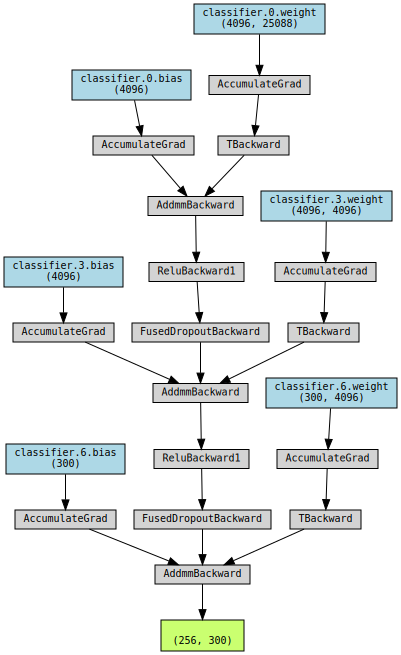

In [ ]:
x = torch.randn(batch_size, 3, 224, 224).cuda()
make_dot(vgg19.vgg19(x), params=dict(vgg19.vgg19.named_parameters()))

In [ ]:
def train_model(model, train_loader, valid_loader):

  criterion = nn.TripletMarginLoss()
  optimizer = torch.optim.Adam(model.parameters())

  epoch_losses = []
  epoch_predictions = []
  epoch_actuals = []

  for epoch in range(1, 20):

    total_loss = 0

    model.train()

    for anchor_image, positive_image, negative_image, anchor_text, positive_text, negative_text in tqdm(train_loader):
      optimizer.zero_grad()

      anchor_output = model(anchor_image, anchor_text)
      positive_output = model(positive_image, positive_text)
      negative_output = model(negative_image, negative_text)


      loss = criterion(anchor_output, positive_output, negative_output)
      total_loss += loss.item()

      loss.backward()
      optimizer.step()

    print()
    print('epoch: {}, train loss: {}'.format(epoch, total_loss/len(train_loader)))

    model.eval()

    total_loss = 0

    actual = []
    predicted = []

    for anchor_image, positive_image, negative_image, anchor_text, positive_text, negative_text in tqdm(valid_loader):
      with torch.no_grad():
        anchor_output = model(anchor_image, anchor_text)
        positive_output = model(positive_image, positive_text)
        negative_output = model(negative_image, negative_text)

        loss = criterion(anchor_output, positive_output, negative_output)
        total_loss += loss.item()
      
      positive_predicted = torch.where(F.cosine_similarity(anchor_output, positive_output, dim=1) > 0.5, 1, 0).detach().cpu().numpy().tolist()
      negative_predicted = torch.where(F.cosine_similarity(anchor_output, negative_output, dim=1) > 0.5, 1, 0).detach().cpu().numpy().tolist()

      predicted += positive_predicted + negative_predicted
      actual += [1] * len(anchor_output) + [0] * len(anchor_output)

    print()
    print('epoch: {}, valid loss: {}'.format(epoch, total_loss/len(valid_loader)))

    epoch_losses.append(total_loss)
    epoch_predictions.append(predicted)
    epoch_actuals.append(actual)

    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
        }, '/content/drive/Shareddrives/CIS 522 Final Project/vgg_model_epoch_{}'.format(epoch))

    with open('/content/drive/Shareddrives/CIS 522 Final Project/vgg_valid_losses.npy', 'wb') as f:
      np.save(f, np.array(epoch_losses))
    with open('/content/drive/Shareddrives/CIS 522 Final Project/vgg_valid_actuals.npy', 'wb') as f:
      np.save(f, np.array(epoch_actuals))
    with open('/content/drive/Shareddrives/CIS 522 Final Project/vgg_valid_predictions.npy', 'wb') as f:
      np.save(f, np.array(epoch_predictions))

  return epoch_losses, epoch_predictions, epoch_actuals

In [ ]:
def inference_model(model, inference_loader):

  model.eval()

  outputs = []
  labels = []

  with torch.no_grad():
    for batch_images, batch_texts, batch_labels in tqdm(inference_loader):
      output = model(batch_images, batch_texts)

      outputs += output.detach().cpu().numpy().tolist()
      labels += batch_labels.detach().cpu().numpy().tolist()

  return outputs, labels

In [ ]:
epoch_losses, epoch_predictions, epoch_actuals = train_model(vgg19, train_loader, valid_loader)

  0%|          | 0/74 [00:00<?, ?it/s]


epoch: 1, train loss: 0.09302209894460572


100%|██████████| 74/74 [13:27<00:00, 10.91s/it]



epoch: 1, valid loss: 0.25221522774144606


 27%|██▋       | 135/492 [25:01<1:06:03, 11.10s/it]

In [ ]:
epoch_losses = np.load('/content/drive/Shareddrives/CIS 522 Final Project/valid_losses.npy')
epoch_predictions = np.load('/content/drive/Shareddrives/CIS 522 Final Project/valid_predictions.npy')
epoch_actuals = np.load('/content/drive/Shareddrives/CIS 522 Final Project/valid_actuals.npy')

In [ ]:
fig = plt.figure()
plt.plot(epoch_losses/len(valid_loader))
# plt.xlim((0,5))
plt.xlabel('epoch', fontsize=16)
plt.ylabel('Validation Triplet Loss', fontsize=16)

In [ ]:
best_epoch = np.argmin(epoch_losses)
best_epoch

In [ ]:
fpr, tpr, thresholds = roc_curve(epoch_actuals[best_epoch].reshape(-1), epoch_predictions[best_epoch].reshape(-1))
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=16)
plt.show()

In [ ]:
points = [accuracy_score(epoch_actuals[i].reshape(-1), epoch_predictions[i].reshape(-1)) for i in range(len(epoch_actuals))]

fig = plt.figure()
plt.plot(points)
plt.xlabel('epoch', fontsize=16)
plt.ylabel('Validation accuracy score', fontsize=16)
plt.ylim([0, 1])

In [ ]:
points = [f1_score(epoch_actuals[i].reshape(-1), epoch_predictions[i].reshape(-1)) for i in range(len(epoch_actuals))]
##### average?
fig = plt.figure()
plt.plot(points)
plt.xlabel('epoch', fontsize=16)
plt.ylabel('Validation F1 score', fontsize=16)

In [ ]:
all_outputs = []
all_labels = []

for epoch in range(1, 9):
  vgg19.load_state_dict(torch.load('/content/drive/Shareddrives/CIS 522 Final Project/vgg_model_epoch_{}'.format{epoch})['model_state_dict'])
  outputs, labels = inference_model(vgg19, inference_loader)

  all_outputs.append(outputs)
  all_labels.append(labels)

  with open('/content/drive/Shareddrives/CIS 522 Final Project/vgg_valid_outputs.npy', 'wb') as f:
    np.save(f, np.array(all_outputs))
  with open('/content/drive/Shareddrives/CIS 522 Final Project/vgg_valid_labels.npy', 'wb') as f:
    np.save(f, np.array(all_labels))

In [ ]:
outputs = np.load('/content/drive/Shareddrives/CIS 522 Final Project/vgg_valid_outputs.npy')
labels = np.load('/content/drive/Shareddrives/CIS 522 Final Project/vgg_valid_labels.npy')

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(outputs, labels, test_size=0.20, stratify=labels, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(outputs, labels, test_size=0.20, random_state=1)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
knn.fit(X_train, y_train)

In [ ]:
results = knn.predict(X_test)

In [ ]:
accuracy_score(y_test, results)

In [ ]:
f1_score(y_test, results, average='micro')

In [ ]:
f1_score(y_test, results, average='macro')

In [ ]:
f1_score(y_test, results, average='weighted')